In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format ='retina'
from datetime import datetime
import pandas_datareader.data as web
from urllib.request import urlopen
import pyfolio as pf
import logging
import investpy
logging.getLogger().setLevel(logging.CRITICAL)
import ipywidgets as widgets
from ipywidgets import interact
import scipy.stats as stats
import pyfolio as pf
#plt.rcParams['figure.figsize'] = (16, 8)

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
link = 'https://squeezemetrics.com/monitor/static/DIX.csv'
df = pd.read_csv(urlopen(link),index_col='date')
df.index = pd.to_datetime(df.index)

In [3]:
def annualised_sharpe(returns, N=252):
    try:
        result = np.sqrt(N) * (returns.mean() / returns.std())
    except ZeroDivisionError:
        result = 0
    return result

def z_score(x,window):
    z = (x - x.rolling(window).mean())/ x.rolling(window).std()
    return z

In [4]:
def return_calculator(df,signal_threshold,plot=False,signal_line='dix',title='',y_lim=[0.3,0.6],sell_thresh=False,**kwargs):

    df['log_returns'] = np.log(df.price/df.price.shift(1))
    df['pos_returns'] = df['log_returns'] * df['position']
    df['cum_returns'] = np.exp(df['pos_returns'].cumsum())
    
    df['max_pct_drawdown'] = (df['cum_returns'] / df['cum_returns'].cummax()).cummin()
    
    period_days = (df.index[-1] - df.index[0]).days
    period_years =  period_days / 365.25
    annualised_return = (((df['cum_returns'][-1])**(1/period_years))-1)
    
    if plot==True:
        fig,(ax,ax3) = plt.subplots(2,1,sharex=True,
                                        gridspec_kw={'height_ratios':[1,0.25]})
        fig.suptitle(str(title)+'Strategy Returns: Ann. Return = '+str(np.round(annualised_return*100,1))
                     +'%, Sharpe = '+str(np.round(annualised_sharpe(df['pos_returns']),1)),
                     y=1.02,fontsize=16)
        fig.tight_layout()
        
        ax.plot(df['cum_returns'],label='Strategy Returns')
        ax.plot(np.exp(df['log_returns'].cumsum()),label='Markets Returns')
        ax.set_ylabel('Log Returns')
        ax.legend()
        
        ax2 = ax.twinx()
        ax2.plot(df[signal_line],alpha=0.3,c='black',ls='-')
        ax2.fill_between(df.index,df['position']*np.max(df[signal_line])*1.5,0,df['position']>0,alpha=0.1)
        if signal_line == 'dix':
            ax2.set_ylim(y_lim)
        ax2.grid(None)
        
        ax2.axhline(signal_threshold,c='green',alpha=0.5)
        if sell_thresh == True:
            sell_thresh=-signal_threshold
            ax2.axhline(sell_thresh,c='red',alpha=0.5) 
    
        ax2.set_ylabel(signal_line)
        
        ax3.plot(df['max_pct_drawdown'] - 1,color='red',lw=1.5,label='Max DD',ls='--')
        ax3.plot((df['cum_returns'] / df['cum_returns'].expanding().max()) - 1,
                  color='tab:red',ls='-',label='Underwater')
        ax3.fill_between(df.index,df['cum_returns'] / df['cum_returns'].expanding().max() - 1,0,
                          (df['cum_returns'] / df['cum_returns'].expanding().max())<1,color='tab:red',alpha=0.3,interpolate=True)
        ax3.set_ylabel('Underwater Plot %')
        ax3.grid()
        
    df_output = df
        
    return (df_output['cum_returns'][-1],
            annualised_sharpe(df_output['pos_returns']),
            df_output['max_pct_drawdown'][-1] - 1, 
            np.count_nonzero(df_output['position'])/len(df_output['position']), 
            annualised_return,
            df_output
           )
    #return output = cum. log returns, last ann. sharpe, max drawdown, % time in market, ann. return, dataframe

In [5]:
def simple_dix_strategy(df,period_returns,signal_threshold,**kwargs):
    df['dix_signal'] = np.where(df['dix']>signal_threshold,1,0)
    df['position'] = np.where(df['dix_signal'].shift(1).rolling(period_returns,min_periods=1).sum()>0,1,0)
    return return_calculator(df,signal_threshold,**kwargs)

In [6]:
def matrix_creator(strategy_function,df,params,metric_output,annot=True,signal_line='dix',**kwargs):

    strategy = {}
    for i in metric_output:
        strategy[i] = np.zeros(tuple([len(p) for p in params]))
        
    for i, x in enumerate(params[0]):
        for j, y in enumerate(params[1]):
            (pnl,sharpe,dd,time,*_) = strategy_function(df=df,
                                                        period_returns=x,
                                                        signal_threshold=y,
                                                        plot=False,
                                                        **kwargs)                                             
            strategy[metric_output[0]][i,j] = pnl
            strategy[metric_output[1]][i,j] = sharpe
            strategy[metric_output[2]][i,j] = dd
            strategy[metric_output[3]][i,j] = time

    fig,axes = plt.subplots(int(len(metric_output)/2),int(len(metric_output)/2),
        figsize=(14,8))
    
    cmaps = ['RdBu','RdYlGn','Reds_r','Purples']
    centres = [True,True,False,False]
    max_min = ['Max','Max','Max','Min']
    
    for metric_i, row in enumerate(axes.flatten()):
        i_maxormin,j_maxormin = np.where(max_min[metric_i]=='Max',
                                     np.unravel_index(np.nanargmax(strategy[metric_output[metric_i]]),
                                                      strategy[metric_output[metric_i]].shape),
                                     np.unravel_index(np.nanargmin(strategy[metric_output[metric_i]]),
                                                      strategy[metric_output[metric_i]].shape))
        midpoint = (strategy[metric_output[metric_i]].max() - strategy[metric_output[metric_i]].min()) / 2
        sns.heatmap(strategy[metric_output[metric_i]],annot=annot,ax=axes.flat[metric_i], #ax=row
                    xticklabels=np.round(params[1],3),yticklabels=np.round(params[0],2),
                    cmap=cmaps[metric_i],center=np.where(centres[metric_i]==True,0,midpoint),
                    cbar_kws={'label':str(metric_output[metric_i])}).invert_yaxis()
        
        row.set_title(str(metric_output[metric_i])+' '+str(max_min[metric_i])+'=%.2f' %strategy[metric_output[metric_i]][i_maxormin,j_maxormin]\
                      +': Period returns=%.1f' %period_returns_rng[i_maxormin] + ', '+signal_line+' threshold=%.2f' %signal_threshold_rng[j_maxormin],
                      fontdict={'fontsize':14})
        row.set_xlabel(signal_line+' threshold')
        row.set_ylabel('period returns')
    
        fig.tight_layout(pad=1)
    return

In [7]:
period_returns_rng = [2,3,4,5,7,10,15,20,25,30,35,40,45,50,55,60]
signal_threshold_rng = [0.4,0.41,0.42,0.43,0.44,0.45,0.455,0.46,0.465,0.47,0.48,0.5]

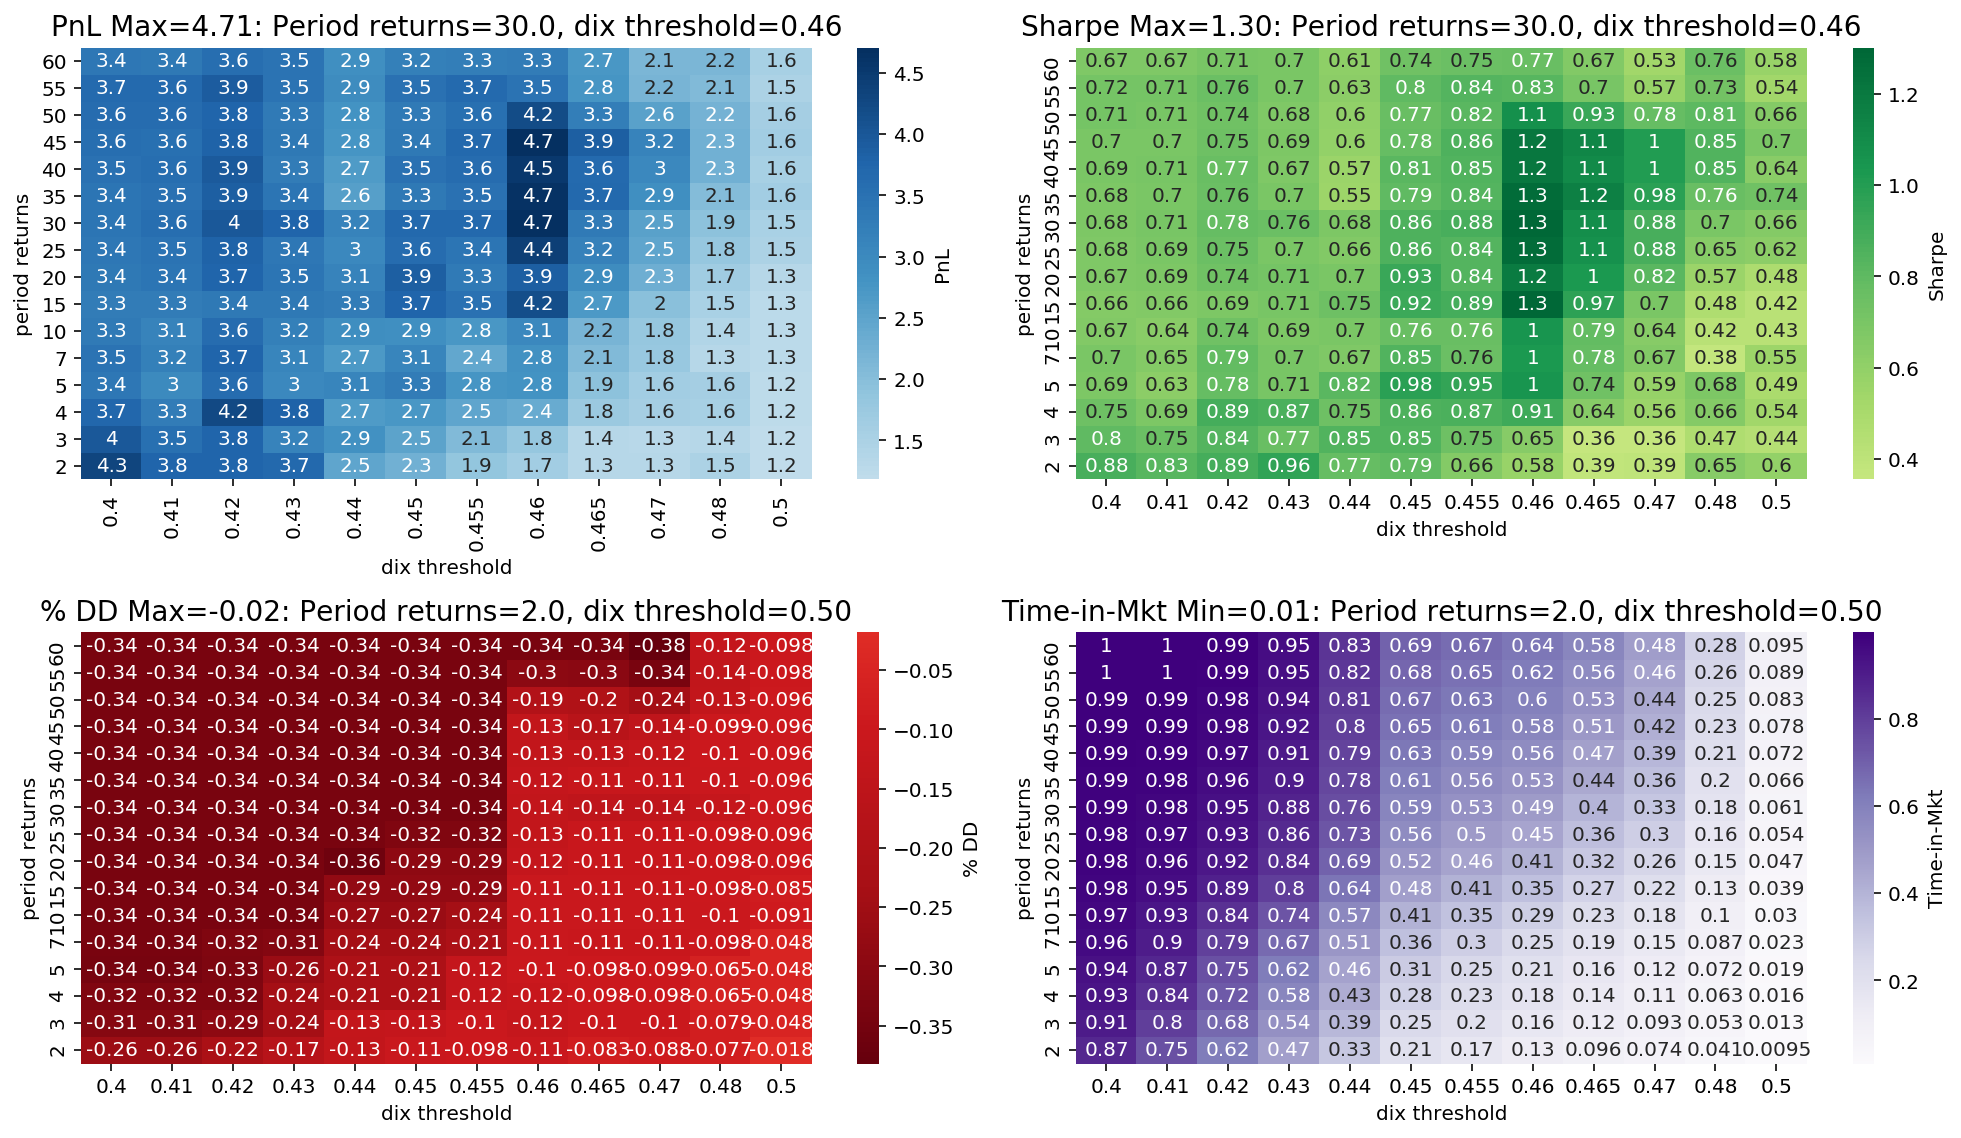

In [8]:
matrix_creator(strategy_function=simple_dix_strategy,df=df, 
               params =[period_returns_rng,signal_threshold_rng],
               metric_output=('PnL','Sharpe','% DD','Time-in-Mkt'))

(4.174651237038163,
 1.2990559437288092,
 -0.10512049825440495,
 0.3547655068078669,
 0.1458808304610082)

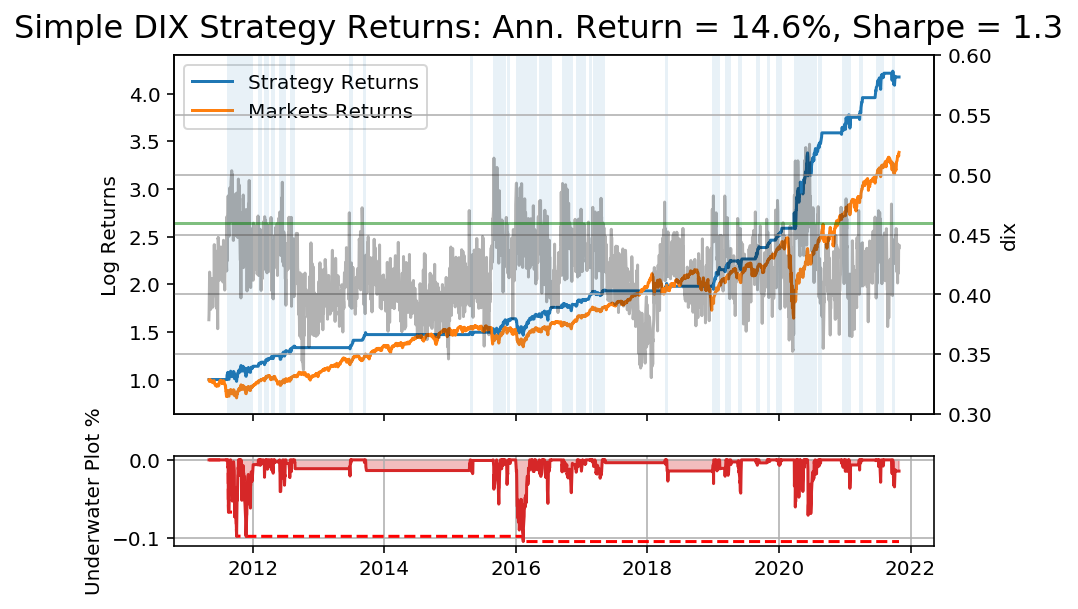

In [9]:
simple_dix_strategy(df,15,0.46,plot=True,title='Simple DIX ')[:-1]

In [10]:
days=15
df_returns = df
df_returns[str(days)+'d_returns'] = (df_returns.price/df_returns.price.shift(days) -1) * 100
df_returns[str(days)+'d_fwd_returns'] = df_returns[str(days)+'d_returns'].shift(-days)

In [11]:
df_returns.groupby(by='dix_signal')[str(days)+'d_fwd_returns'].describe(percentiles=[0.10,0.90])

,count,mean,std,min,10%,50%,90%,max
dix_signal,,,,,,,,
0,2405.0,0.592795,3.562637,-27.598325,-3.266332,1.039457,3.881607,27.203897
1,224.0,2.555814,3.800859,-8.163644,-1.400376,2.251281,7.122286,15.664316


In [12]:
df_returns[str(days)+'d_fwd_returns'].describe(percentiles=[0.1,0.9])


count    2629.000000
mean        0.760051
std         3.624482
min       -27.598325
10%        -3.167160
50%         1.141913
90%         4.159559
max        27.203897
Name: 15d_fwd_returns, dtype: float64

In [13]:
def strategy_dix_gex_buy_sell(df,signal_threshold,period_returns,**kwargs):
    ''' Strategy with buy, sell and early exit signals '''
    
    indic_columns = ['dix','gex']
    for i in indic_columns: 
        metric = '_z_score'
        df[str(i)+metric] = z_score(df[i],window=period_returns)

    df["_".join(indic_columns)+'_divergence'] = df[df.columns[df.columns.str.contains(metric)]].diff(axis=1).iloc[:,-1].apply(lambda x: x *-1)
    
    df['buy_sig'] = np.where(df['dix_gex_divergence']>signal_threshold,1,0)
    df['sell_sig'] = np.where(df['dix_gex_divergence']<-signal_threshold,-1,0)
    
    df['position_loop'] = 0
    df['count_loop'] = 0
    count = 0
    position = 0
    
    for i, row in df.iterrows():
        #create max holding period = period_returns
        if count >= period_returns:
            position = 0
            count = 0
        #if no position, create position if buy/sell signal triggered
        if position == 0:
            if row['buy_sig'] == 1:
                position = 1
                count = count + 1
            elif row['sell_sig'] == -1:
                position = -1
                count = count + 1
        #if long: close, (flip) or hold
        elif position == 1:
            if row['sell_sig'] == -1:
                position = 0
                count = 0
            else:
                count = count+1
        #if short: close or hold
        elif position == -1:
            if row['buy_sig'] == 1:
                position = 0
                count = 0
            else:
                count = count + 1
            
        df.loc[i,'position_loop'] = position
        df.loc[i,'count_loop'] = count
    
    #shift so position is for next day
    df['position'] = df['position_loop'].shift(1)
    
    return return_calculator(df,signal_threshold,**kwargs)

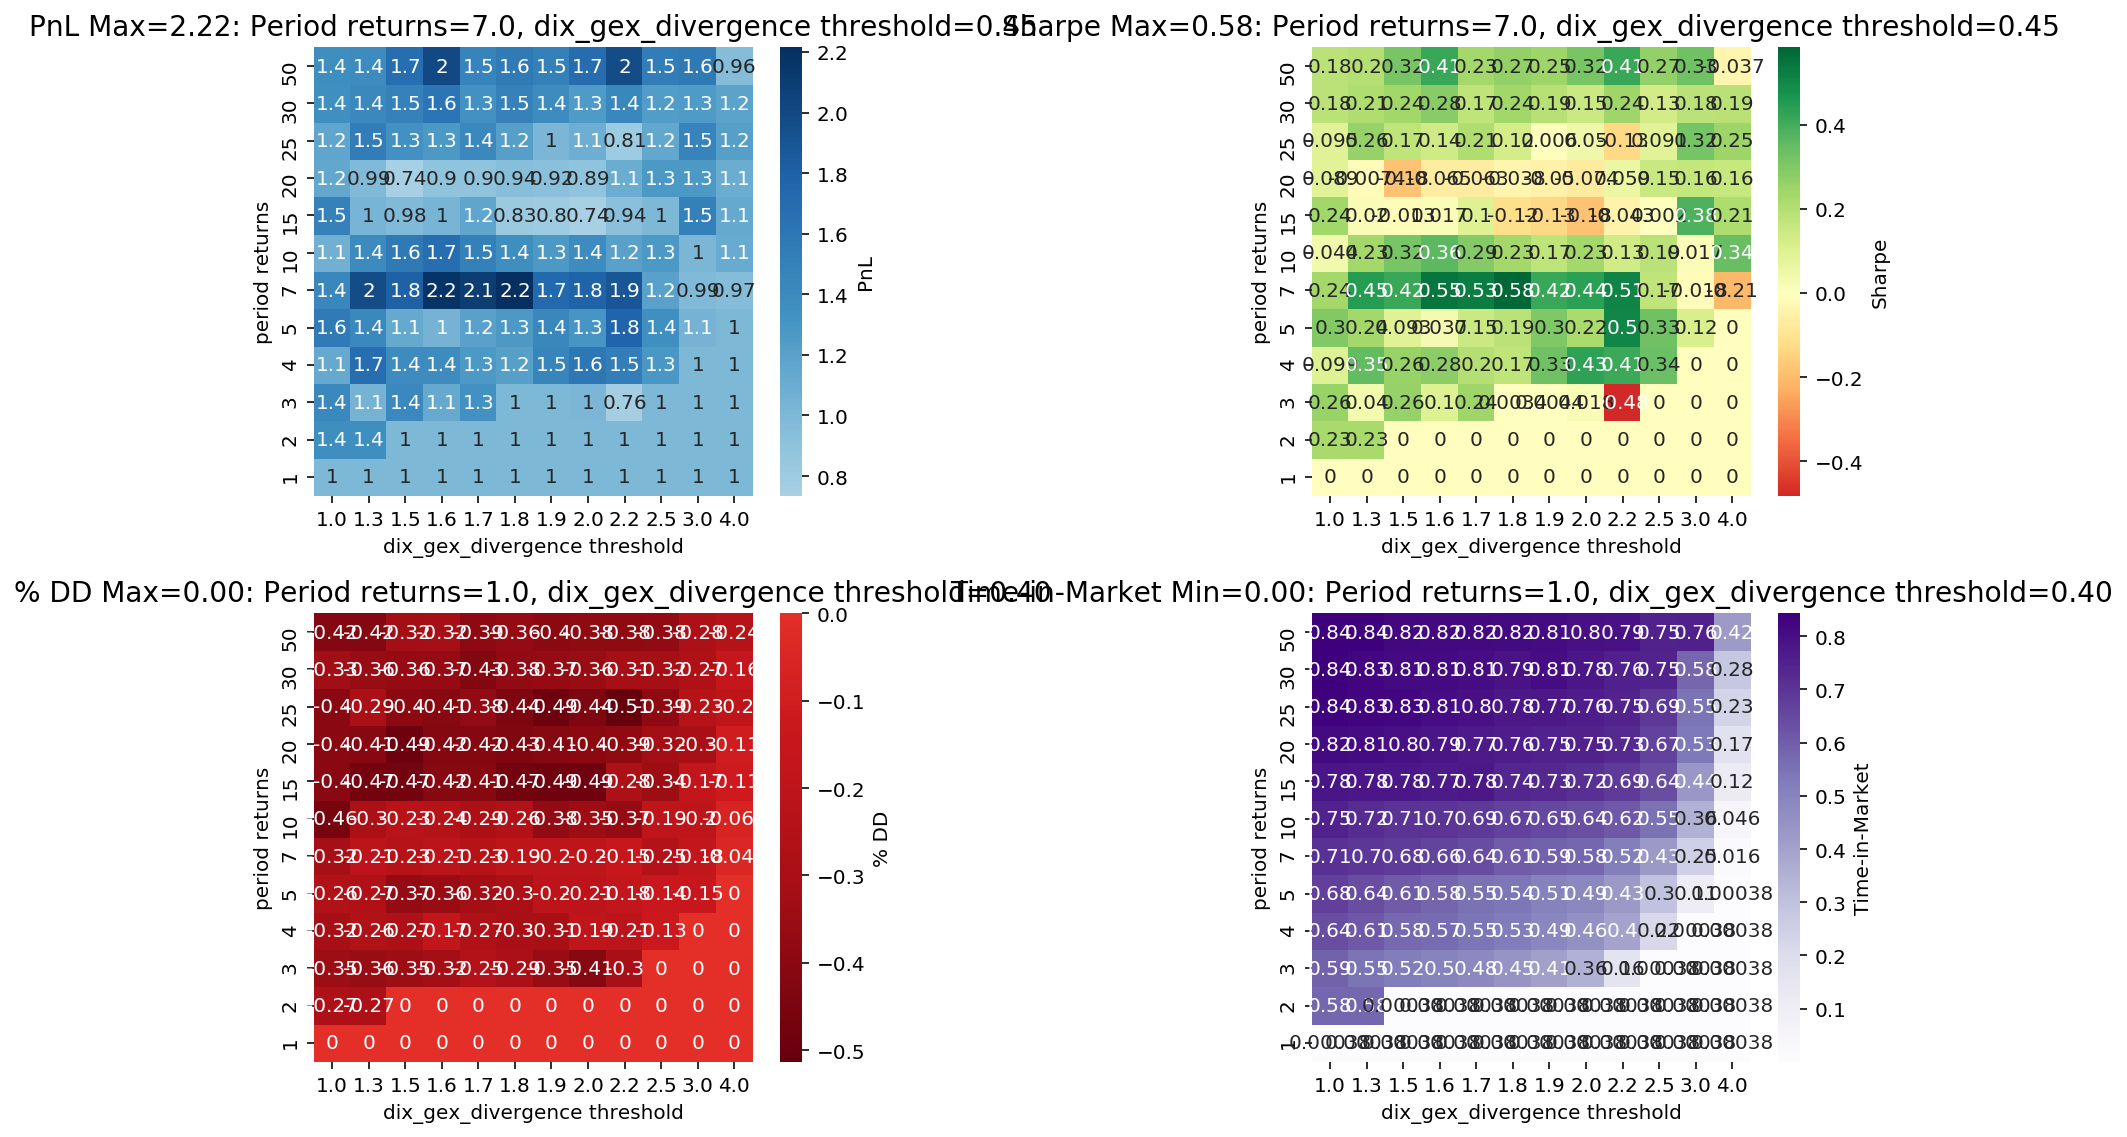

In [14]:
period_returns_rng = [1,2,3,4,5,7,10,15,20,25,30,50]
dix_gex_threshold_rng = [1,1.3,1.5,1.6,1.7,1.8,1.9,2,2.2,2.5,3,4]

matrix_creator(strategy_function=strategy_dix_gex_buy_sell,df=df, 
               params =[period_returns_rng,dix_gex_threshold_rng],
               metric_output=('PnL','Sharpe','% DD','Time-in-Market'),signal_line='dix_gex_divergence')

(2.1056654384497278,
 0.5286759018743176,
 -0.23222223193600355,
 0.642965204236006,
 0.0735346396633274)

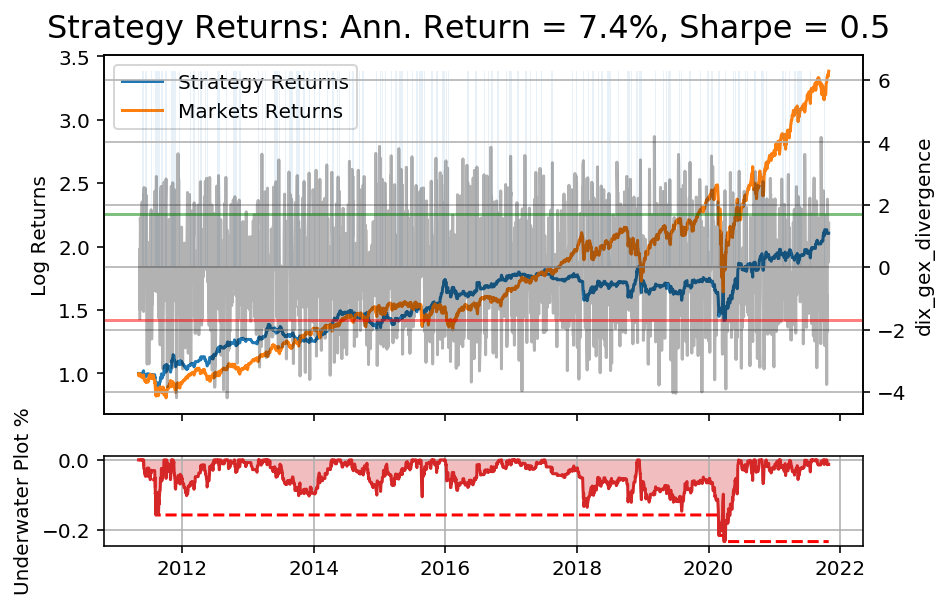

In [15]:
strategy_dix_gex_buy_sell(df=df,period_returns=7,signal_threshold=1.7,
                             plot=True,signal_line='dix_gex_divergence',sell_thresh=True)[:-1]